In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

---

<h1><center>SDSE Lab 4 <br><br> Linear regression and Feature selection </center></h1>

---

In this lab we will use linear regression to predict cancer mortality rates based on data obtained from the American Community Survey of the [U.S. Census Bureau](https://www.census.gov/). The lab has four parts. In part 1 you will load the data and do basic manipulations using [pandas](https://pandas.pydata.org/docs/index.html). Pandas is a Python package that specializes in tabular data. It is widely used in data science and machine learning since the data in these fields are usually structured as a table. Pandas is a very powerful library that is well worth investing some time to learn [here](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) and [here](https://pandas.pydata.org/docs/user_guide/index.html).

In part 2 you will perform linear regression on the full feature set. In part 3 you will compute confidence intervals and perform hypothesis tests on the paramters from part 2. Finally, in part 4 you will run the forward and backward stepwise feature selection algorithms and estimate the performance of the resulting model using a test dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

<h1><font color='purple'> Part 1:  Loading and cleaning the data</font></h1>

## 1.1 Load the data into a pandas DataFrame

See a description of the data [here](https://data.world/nrippner/ols-regression-challenge).

Use [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to load the data from `cancerdata.csv`.

You can obtain information about the data using these DataFrame methods:
+ `data.head()` to see the first 5 rows of the DataFrame.
+ `data.tail()` to see the last 5 rows of the DataFrame.
+ `data.shape` is the tuple (number of rows, number of columns).
+ `data.columns` contains the column labels.
+ `data.index` contains the row labels.

In [3]:
data = pd.read_csv(".\cancerdata.csv")  # TODO

## 1.2 Inspect columns

Run `data.info()` and note:
 a) which features are non-numerical (Dtype=object), and
 b) which features have null entries (Non-Null Count<3047).

Store the names ('Column' entry) of the non-numerical features in the set `non_numerical_features`. Store the names of features with null entries in the set `null_entry_features`.

**Note**: If not all of the rows of `data.info()` are displayed, you'll probably have this message at the bottom:

*``Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...''*

In [4]:
data.info()
non_numerical_features = {col for col in data.columns if data[col].dtype == 'object'}
null_entry_features = {col for col in data.columns if data[col].count() < 3047}



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target_deathrate         3047 non-null   float64
 1   incidencerate            3047 non-null   float64
 2   medincome                3047 non-null   int64  
 3   povertypercent           3047 non-null   float64
 4   binnedinc                3047 non-null   object 
 5   medianage                3047 non-null   float64
 6   geography                3047 non-null   object 
 7   avghouseholdsize         3047 non-null   float64
 8   percentmarried           3047 non-null   float64
 9   pctnohs18_24             3047 non-null   float64
 10  pcths18_24               3047 non-null   float64
 11  pctsomecol18_24          762 non-null    float64
 12  pctbachdeg18_24          3047 non-null   float64
 13  pcths25_over             3047 non-null   float64
 14  pctbachdeg25_over       

In [5]:
grader.check("q1p2")

q1p2 results: All test cases passed!

## 1.3 Discard non-numerical columns

Remove the two columns with non-numeric data.

Hints:
+ `data.dtypes` lists the data types for each column.
+ You can construct a boolean indicator array of non-numeric colums with `data.dtypes=='object'`.
+ Use that array to index `data.columns`
+ Use [`data.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) to remove the selected columns

In [6]:
ind = data.dtypes == 'object'
drop_cols = data.columns[ind]
data = data.drop(columns=drop_cols)


In [7]:
grader.check("q1p3")

q1p3 results: All test cases passed!

## 1.4 Discard columns where more than 10% of values are nan

Hints:
+ [`data.dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
+ `axis=1` ... we are dropping columns
+ `thresh` ... The condition for dropping a column is that it has less than `round(0.9*data.shape[0])` non-nans.


In [8]:
thresh = round(0.9 * data.shape[0])
data = data.dropna(axis=1, thresh=thresh)
data.shape

(3047, 24)

In [9]:
grader.check("q1p4")

q1p4 results: All test cases passed!

## 1.5 Drop all rows that contain one or more nans.

Hint: You can again use `data.dropna` for this.

In [10]:
data = data.dropna()      # TODO

In [11]:
grader.check("q1p5")

q1p5 results: All test cases passed!

## 1.6 Inspect correlations

Next we'll look at the correlation coefficients between each of the features and the target variable `target_deathrate`.

1) Use `data.corr()` to build the correlations matrix.
2) Inspect the column (or row) corresponding to `target_deathrate`.
3) Rank (i.e. sort) the features from most to least correlated with the output. This ranking is in terms of the absolute value of the correlation coefficient.
4) Save the top 5 correlated features to `top_5_corr`. `top_5_corr` should be a numpy array with shape `(5,)`.

Hints:
+ [`abs`](https://pandas.pydata.org/docs/reference/api/pandas.Series.abs.html)
+ [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html)
+ [`to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_numpy.html)

In [12]:
C = data.corr()
corr_target = C['target_deathrate']
corr_target_sort = corr_target.abs().sort_values(ascending=False)
top_5_sort = corr_target_sort.index[1:6].to_numpy()

In [13]:
grader.check("q1p6")

q1p6 results: All test cases passed!

## 1.7 Scatter plot

Make a scatter plot of the data with the most correlated feature along the x axis, and the target along the y axis.

Hint: You can use the plotting function attached to the DataFrame: [data.plot(kind='scatter',x=..., y=...)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

<Axes: xlabel='pctbachdeg25_over', ylabel='target_deathrate'>

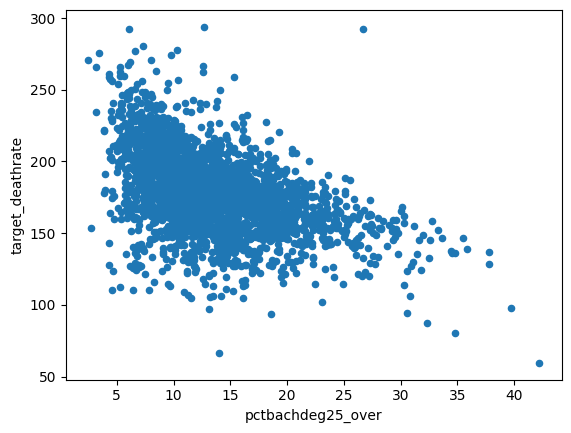

In [14]:
data.plot(kind='scatter', x=top_5_sort[0], y='target_deathrate')

---

<h1><font color='purple'> Part 2: Linear regression </font></h1>

## 2.1 Extract data matrices

The next cell extracts the `X` and `Y` matrices from `data`. It also makes a list of `features`, and defines the number of samples `N` and the number of features `P`.

In [15]:
X = data.drop(columns='target_deathrate').values
features = data.columns.values
features = features[features != 'target_deathrate']
Y = data['target_deathrate'].values

N, P = X.shape


In [16]:
grader.check("q2p1")

q2p1 results: All test cases passed!

## 2.2 Center the inputs

\begin{align*}
\hat\mu_X &= \frac{1}{N} \mathbf{1}^T_N \mathbf{X} \\
\mathbf{X}^c&=\mathbf{X}-\mathbf{1}_N\hat\mu_X
\end{align*}

Compute the column-wise means `muhatX` and subtract them from `X` to obtain `Xc`. 

Hint: 
+ Use `X.mean(axis=...)`. Should it be `axis=0` or `axis=1`? 
+ The formula for `Xc` above has $\mathbf{1}_N\hat\mu_X$. The broadcasting rules of numpy make multiplying $\hat\mu_X$ by $\mathbf{1}_N$ unnecessary.

Check that the column-wise means of `Xc` equal zero (to machine precision). 

In [17]:
muhatX = X.mean(axis=0)
Xc = X - muhatX

In [18]:
grader.check("q2p2")

q2p2 results: All test cases passed!

## 2.3 Center the outputs

\begin{align*}
\hat\mu_Y &= \frac{1}{N} \mathbf{1}^T_N \mathbf{Y} \\
\mathbf{Y}^c&=\mathbf{Y}-\mathbf{1}_N\hat\mu_Y
\end{align*}


In [19]:
muhatY = Y.mean()
Yc = Y - muhatY


In [20]:
grader.check("q2p3")

q2p3 results: All test cases passed!

## 2.4 Compute the inverse input covariance martrix.

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

$$\Sigma^{-1}_X=( (\mathbf{X}^c)^T \mathbf{X}^c)^{-1}$$

Hints:
+ numpy's @ operator and matrix transposition (`Xc.T`). See [this](https://numpy.org/devdocs/user/numpy-for-matlab-users.html) summary of the key differences between numpy and Matlab.
+ [np.linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)


In [35]:
InvCovX = np.linalg.inv(Xc.T @ Xc)

In [36]:
grader.check("q2p4")

q2p4 results: All test cases passed!

## 2.5 Compute the least squares estimates of the parameters

\begin{align*}
\underline{\hat\theta}_1 &= \Sigma^{-1}_X(\mathbf{X}^c)^{T} \mathbf{Y}^c \\
\hat\theta_0 &= \hat\mu_Y - \hat\mu_X \underline{\hat\theta}_1
\end{align*}

In [63]:
theta1hat = InvCovX @ Xc.T @ Yc  # TODO
theta0hat = muhatY - np.dot(muhatX, theta1hat)  # TODO

In [64]:
grader.check("q2p5")

q2p5 results: All test cases passed!

## 2.6 Compute predictions for each of the samples

$$\mathbf{\hat{Y}} = \mathbf{1}_N\hat\theta_0 + \mathbf{X}\underline{\hat\theta}_1$$


In [75]:
ones_N = np.ones(X.shape[0])
Yhat = ones_N * theta0hat + X @ theta1hat

In [76]:
grader.check("q2p6")

q2p6 results: All test cases passed!

# 2.7 Model performance

Compute the coefficient of determination $R^2$ for this model on the trainging data.

$$ R^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{y}_i)^2}{\sum_{i=1}^N (y_i-\hat\mu_X)^2}$$

In [78]:
R2 = 1 - (np.sum((Y - Yhat)**2)/(np.sum((Y - muhatY)**2)))

In [79]:
grader.check("q2p7")

q2p7 results: All test cases passed!

---

<h1><font color='purple'> Part 3: Parameter uncertainty and hypothesis test</font></h1>

## 3.1 Estimate the variance of the output

$$\hat\sigma^2 = \frac{1}{N-P-1} \sum_{i=1}^{N}(y_i-\hat{y}_i)^2$$

In [80]:
sigmahat2 = 1 / (N - P - 1) * np.sum((Y - Yhat)**2)

In [81]:
grader.check("q3p1")

q3p1 results: All test cases passed!

## 3.2 Compute the variances of the slope parameters

These are the diagonal entries of 
$$Var[\underline{\hat\Theta}_1] = \hat\sigma^2 \Sigma^{-1}_X $$

In other words, the variance of $\hat\theta_p$ is the $p$'th diagonal entry of $Var[\underline{\hat\Theta}_1]$.

**Hint**: [`np.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)

In [87]:
sigma2_hat = np.sum(((Y - Yhat)**2) / (Xc.shape[0] - Xc.shape[1] - 1))
var_theta1_hat_matrix = sigma2_hat * InvCovX  
var_thetahat = np.diag(var_theta1_hat_matrix)


In [88]:
grader.check("q3p2")

q3p2 results: All test cases passed!

## 3.3 Conduct a hypothesis test on each of the parameters, with the null hypothesis that the parameter value is zero. Use a significance level of $\alpha=0.05$.

### 3.3.1 Compute Z statistic for each parameter

We know that all of the parameters are Gaussian with variance given by the $p$'th diagonal entry in $\hat\sigma^2 \Sigma^{-1}_X$. We denote this variance as $v_p$. Then $v_p$ is the $p$-th entry in `var_thetahat`. To evaluate the hypothesis test we need to compute the z-statistic.

$$Z_p = \frac{\hat\theta_p}{\sqrt{v_p}}$$

Construct an array $Z$ with entries equal to these $Z_p$'s

In [ ]:
Z =     # TODO

In [ ]:
grader.check("q3p3p1")

### 3.3.2. Compute the p-value for each parameter

$$p_i = 2\: \Phi_{\mathcal{N}}(-|Z_i|)$$

In [ ]:
p = ...   # TODO

In [ ]:
grader.check("q3p3p2")

### 3.3.3 Create a boolean mask indicating features that were deemed influential by the hypothesis test (H0 was rejected)

Done already.

In [ ]:
ind_influential = p<0.05
ind_influential

### 3.4 Parameters table.
Make a DataFrame with one row per parameter. The index of the table should be the parameter names. The columns should be:
+ `theta`: the point estimate of the parameter.
+ `stddev`: the estiuamted standard deviation of the parameters.
+ `Z`: Z scores computed in part 3.3.1
+ `p`: p-values compute in part 3.3.2
+ `influential`: the boolean indicator from part 3.3.3.

Done already.

In [ ]:
lr_params = pd.DataFrame(index=features,
             data={'thetahat':theta1hat,
                   'variance':var_thetahat,
                   'Z':Z,
                   'p':p,
                   'influential':ind_influential})

lr_params

## 3.5 Sort the parameters table by p-value

Create a new DataFrame called `lr_params_sorted` by sorting the values in ascending order, according to p-values.

Hint: [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)

In [ ]:
lr_params_sorted = ...   # TODO

In [ ]:
grader.check("q3p5")

## 3.6 Bar plot

The bar plot below shows the parameter values along with their 95% (2$\sigma$) confidence intervals. Influential fetaures are showns in green, non-influential features are shown in red.

In [ ]:
color = np.array(['g' for i in range(P)])
color[~lr_params_sorted['influential']] = 'r'

lr_params_sorted.plot(kind='bar',
                y='thetahat',
                yerr=2*np.sqrt(lr_params_sorted['variance']),
                figsize=(15,5),
                color=color,
                legend=False)
plt.grid(linestyle=':')

## 3.7 Build list of features to keep

Extract the names of influential features from `lr_params_sorted` and store them in `features` (overwrite the previous values). `features` should be a numpy array with shape `(15,)`.

In [ ]:
features = ...  # TODO

In [ ]:
grader.check("q3p7")

## 3.8 Create a new DataFrame with only the chosen features

Done already. Notice that the target variable is now called `Y`.

In [ ]:
D = data[features].copy()
D['Y'] = data['target_deathrate']
D

---

<h1><font color='purple'> Part 4: Feature subset selection</font></h1>

## 4.1 Split D into training, validation, and testing datasets

We will use 70% of the data for training, 15% for validation, and 15% for testing.

1. Define `Dtrain` as the first `Ntrain` rows of `D`.
2. Define `Dvalidate` as the next `Nvalidate` rows of `D`.
3. Define `Dtest` as the last `Ntest` rows of `D`.

Here we use pandas' [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) method for selecting the three datasets.

In [ ]:
Ntrain = round(0.7*N)
Nvalidate = round(0.15*N)
Ntest = N - Ntrain - Nvalidate
Ntrain, Nvalidate, Ntest

Dtrain = D.iloc[:Ntrain,:]
Dvalidate = D.iloc[Ntrain:Ntrain+Nvalidate,:]
Dtest = D.iloc[Ntrain+Nvalidate:,:]

## 4.2 Linear regression training function

Create a function called `train` that receives a list of features `S` and a dataset `Dtrain` and does the following:
1. Selects the features `S` from `D` and stores them in `X`. (done already)
2. Selects the target values from `D` and stores them in `Y`. (done already)
3. Performs the linear regression calculations from parts 2.2, 2.3, and 2.4
4. Returns the estimated parameters $\hat\theta$

In [ ]:
def train(S, Dtrain):

    X = Dtrain[list(S)].values
    Y = Dtrain['Y'].values

    # 2.2 Center the inputs 
    muhatX = ...    # TODO
    Xc = ...    # TODO

    # 2.3 Center the outputs 
    muhatY = ...    # TODO
    Yc = ...    # TODO

    # 2.4 Compute the inverse input covariance matrix
    invCovX = ...    # TODO

    # 2.5 Compute the least squares estimates of the parameters
    theta1hat = ...    # TODO
    theta0hat = ...    # TODO

    return theta0hat, theta1hat

In [ ]:
theta0hat, theta1hat = train(['incidencerate','birthrate'], Dtrain)

In [ ]:
grader.check("q4p2")

## 4.3 Model evluation function

Create a function called `perf` that receives the linear regression parameters `theta0hat` and `theta1hat`, their corresponding feature names `S`, and a dataset `D`, which may be the validation or the training dataset.

The function should evluate the means squared error (MSE) for the model using this data.

The steps are:
1. Select the features `S` from `D` and stores them in `X`. (done already)
2. Select the target values from `D` and stores them in `Y`. (done already)
3. Compute `Yhat`, as in part 2.6.
4. Use the MSE as the performance metric:

$$MSE = \frac{1}{N}\sum_{i=1}^{N} ( y_i-\hat{y}_i)^2$$

In [ ]:
def perf( S, theta0hat, theta1hat, D):

    X = D[list(S)].values
    Y = D['Y'].values

    # 2.6 Compute predictions for each of the samples
    Yhat = ... # TODO

    # 2.7 Model performance
    MSE = ... # TODO
    
    return MSE

In [ ]:
theta0hat, theta1hat = train(['incidencerate','birthrate'], Dtrain)
perf(['incidencerate','birthrate'], theta0hat, theta1hat, Dtrain)

In [ ]:
grader.check("q4p3")

## 4.4 Forward stepwise selection

Following is the code for forward stepwise feature selection that was shown in class. When you run it, it will store the solution in variables with names `f_*`.

This part has no deliverables.

In [ ]:
P = len(features)
curlyP = set(features)

In [ ]:
curlyS = [set() for i in range(P+1)]
ellk = np.full(P+1,np.inf)

for k in range(1,P+1):
    
    curlyA = [set() for i in range(P-k+1)]
    ellkappa = np.full(P-k+1,np.inf)

    for kappa, phip in enumerate(curlyP-curlyS[k-1]):
        curlyA[kappa] = curlyS[k-1].union({phip})
        theta0hat, theta1hat = train( curlyA[kappa] , Dtrain)
        ellkappa[kappa] = perf(curlyA[kappa], theta0hat, theta1hat, 
                               Dvalidate)

    kappastar = ellkappa.argmin()
    curlyS[k] = curlyA[kappastar]
    ellk[k] = ellkappa[kappastar]

kstar = ellk.argmin()
Sstar = curlyS[kstar]
theta0star, theta1star = train(Sstar, Dtrain)
ellstar = perf(Sstar, theta0star, theta1star, Dtest)

# Store the results
f_ellk = ellk
f_ellstar = ellstar
f_kstar = kstar

## 4.5 Backward stepwise selection

Complete the code for backward stepwise selection.

In [ ]:
curlyS = [set() for i in range(P+1)]
curlyS[P] = set(features)
ellk = np.full(P+1,np.inf)

for k in range(...):    # TODO

    assert k+1 == len(curlyS[k+1])
    curlyA = [set() for i in range(k+1)]
    ellkappa = np.full(k+1,np.inf)

    for kappa, phip in enumerate(...):    # TODO
        curlyA[kappa] = ...    # TODO
        theta0hat, theta1hat = train( curlyA[kappa] , Dtrain)
        ellkappa[kappa] = perf(curlyA[kappa], theta0hat, theta1hat, Dvalidate)

    kappastar = ellkappa.argmin()
    curlyS[k] = curlyA[kappastar]
    ellk[k] = ellkappa[kappastar]

kstar = ellk.argmin()
Sstar = curlyS[kstar]
theta0star, theta1star = train(Sstar , Dtrain)
ellstar = perf(Sstar, theta0star, theta1star, Dtest)

# Store the results
b_ellk = ellk
b_ellstar = ellstar
b_kstar = kstar

In [ ]:
grader.check("q4p5")

## Plot

The following plot shows the results of forward and backward stepwise feature selection for this regression problem. In each case, the star indicates the test error for the model with the smallest validation error.

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(range(P+1),f_ellk,'o-',color='blue',label='forward',linewidth=3)
plt.plot([f_kstar,f_kstar],[f_ellk[f_kstar],f_ellstar],color='blue',linestyle='--',linewidth=2)
plt.plot(f_kstar,f_ellstar,'*',color='blue',markersize=22)

c = 'darkorange'
plt.plot(range(P+1),b_ellk,'o-',color=c,label='backward',linewidth=2)
plt.plot([b_kstar,b_kstar],[b_ellk[b_kstar],b_ellstar],color=c,linestyle=':',linewidth=2)
plt.plot(b_kstar,b_ellstar,'*',color=c,markersize=16)
plt.legend(fontsize=16)

plt.grid(linestyle=':')

# plt.ylim(340,480)
# plt.xlim(0,16)
plt.xticks(range(16),fontsize=16)
plt.xlabel('k',fontsize=16)
plt.ylabel('MSE',fontsize=16)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)